## _Histograms_

- Hit Distribution
- Momentum Distribution
- etc

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
# append parent dir
sys.path.append('..')

# local imports
from src import Compose_Event, Draw_Compose_Event

## _Input Data_

In [6]:
# mu- data (old)
# input_dir = './data_sets/pandaml/data_3.0_7.0_GeV/'

# mu+mu- data (current)
input_dir = '../train_quick'

# pbarp data (coming)
# input_dir = os.environ['HOME']+'/current/2_deepana/pandaml/data/'

In [7]:
# Find All Input Data Files (hits.csv, cells.csv, particles.csv, truth.csv)
all_files = os.listdir(input_dir)
all_files[:10]

['event0000005065-truth.csv',
 'event0000006885-hits.csv',
 'event0000005372-hits.csv',
 'event0000005596-cells.csv',
 'event0000008410-truth.csv',
 'event0000006594-hits.csv',
 'event0000000958-truth.csv',
 'event0000009253-particles.csv',
 'event0000001729-truth.csv',
 'event0000008509-truth.csv']

In [8]:
# Extract File Prefixes (use e.g. xxx-hits.csv)
suffix = '-hits.csv'
file_prefixes = sorted(os.path.join(input_dir, f.replace(suffix, '')) for f in all_files if f.endswith(suffix))
file_prefixes[:10]

['../train_quick/event0000000000',
 '../train_quick/event0000000001',
 '../train_quick/event0000000002',
 '../train_quick/event0000000003',
 '../train_quick/event0000000004',
 '../train_quick/event0000000005',
 '../train_quick/event0000000006',
 '../train_quick/event0000000007',
 '../train_quick/event0000000008',
 '../train_quick/event0000000009']

In [9]:
# number of events
len(file_prefixes)

10000

In [10]:
# OR, Extract File Prefixes (only works if we don't have any additional files e.g. *.root, *.log etc.)
all_events = sorted(np.unique([os.path.join(input_dir, event[:15]) for event in all_files]))
all_events[:10]

['../train_quick/event0000000000',
 '../train_quick/event0000000001',
 '../train_quick/event0000000002',
 '../train_quick/event0000000003',
 '../train_quick/event0000000004',
 '../train_quick/event0000000005',
 '../train_quick/event0000000006',
 '../train_quick/event0000000007',
 '../train_quick/event0000000008',
 '../train_quick/event0000000009']

In [11]:
# number of events (in addition to *.csv, *.root and *.log files exists in this dir.)
len(all_events)

10000

In [12]:
event_id = 1

In [13]:
# Fetch an event, use event_id (int)
prefix = "event{:010d}".format(event_id)                     # OR, 
prefix = str('event{!s}'.format(format(event_id, '010d')))   # a little better
event_prefix = os.path.join(input_dir, prefix)              # event_prefix ~ event_file = input_dir + prefix

In [14]:
# hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

In [15]:
# OR, use event_id to fectch one file from list of all files
event_prefix = file_prefixes[event_id]
print(event_prefix)

../train_quick/event0000000001


In [16]:
# load an event
hits, tubes, particles, truth = trackml.dataset.load_event(event_prefix)

# memory usage
mem_bytes = (hits.memory_usage(index=True).sum() 
             + tubes.memory_usage(index=True).sum() 
             + particles.memory_usage(index=True).sum() 
             + truth.memory_usage(index=True).sum())

print('{} memory usage {:.2f} MB'.format(os.path.basename(event_prefix), mem_bytes / 2**20))

event0000000001 memory usage 0.13 MB


In [17]:
# hits.head()
# tubes.head()
# particles.head()
# truth.head()

### _(1) - Detector Layout_

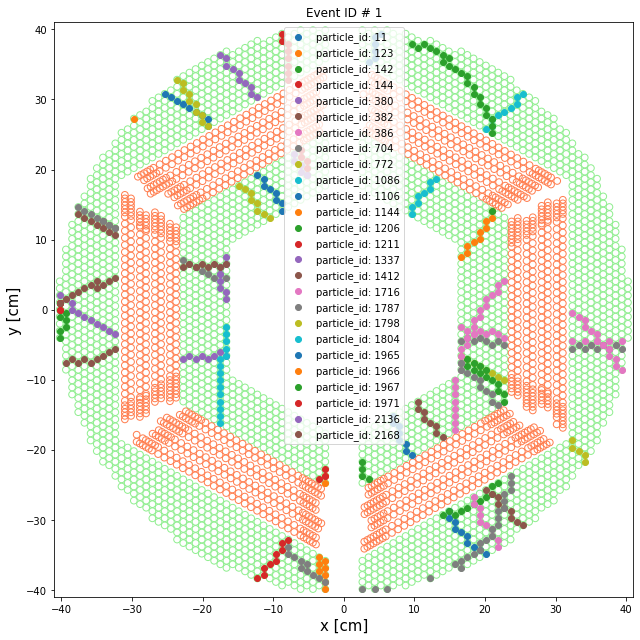

In [23]:
event = Compose_Event(event_prefix, selection=False, noise=False, skewed=False)
Draw_Compose_Event(event,figsize=(9,9));

In [24]:
event.particle_id.unique().shape[0]

26

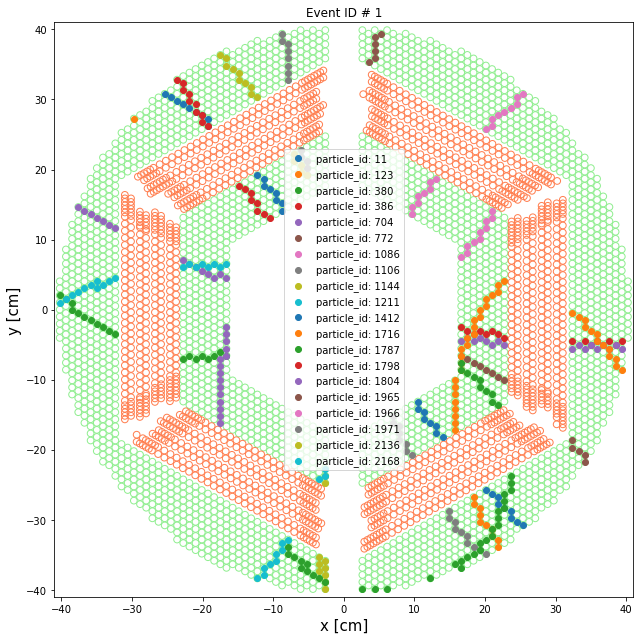

In [25]:
event = Compose_Event(event_prefix, selection=True, noise=False, skewed=False)
Draw_Compose_Event(event,figsize=(9,9));

In [26]:
event.particle_id.unique().shape[0]

20

### _(2) - Draw Individual Tracks_

In [23]:
# preprocess hits
# hits['r'] = hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1)
hits_ = hits.assign(r=hits.apply(lambda row: np.sqrt(row.x**2 + row.y**2), axis=1))
hits_.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,tclone_id,r
0,1,-8.74686,14.140000,35.0,9,0,8,0,16.626700
1,2,-8.74686,15.150000,35.0,9,1,112,1,17.493714
2,3,-9.62154,15.655000,35.0,9,2,223,2,18.375338
3,4,-9.62154,16.665001,35.0,9,3,339,3,19.243084
4,5,-10.49620,17.170000,35.0,9,4,462,4,20.124093


In [24]:
# we already have sorted hits, lets draw a single track.
data = hits_[truth.particle_id == particles.iloc[1,0]]
data.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,tclone_id,r
0,1,-8.74686,14.140000,35.0,9,0,8,0,16.626700
1,2,-8.74686,15.150000,35.0,9,1,112,1,17.493714
2,3,-9.62154,15.655000,35.0,9,2,223,2,18.375338
3,4,-9.62154,16.665001,35.0,9,3,339,3,19.243084
4,5,-10.49620,17.170000,35.0,9,4,462,4,20.124093


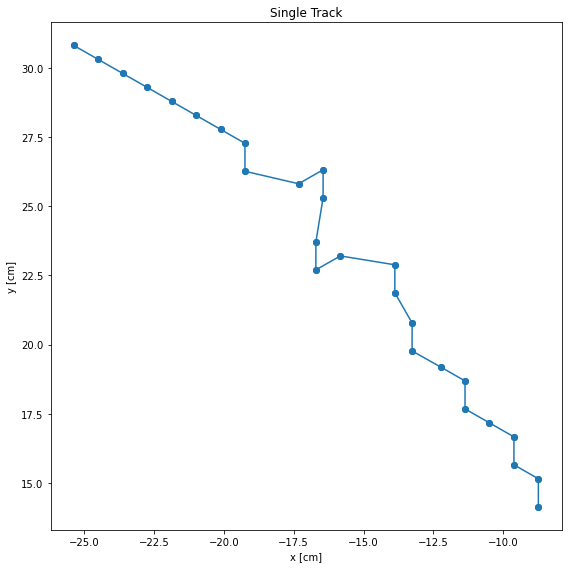

In [25]:
# Using Object Oriented API
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(data.x.values, data.y.values)
ax.plot(data.x.values, data.y.values, "-o")

ax.set_title('Single Track')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
# ax.set_xlim(-40, 40)
# ax.set_ylim(-40, 40)
fig.tight_layout()
# fig.savefig('event.png')

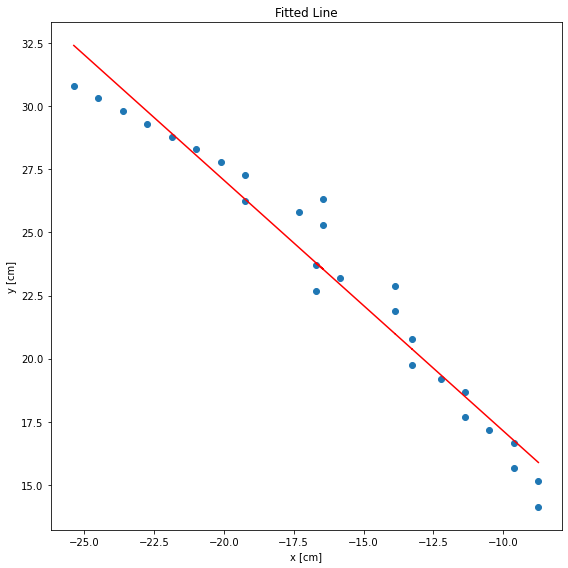

In [26]:
# Using Object Oriented API
plt.close('all')
fig, ax = plt.subplots(figsize=(8,8))

a, b = np.polyfit(data.x, data.y, 1)
y = a*data.x.values + b

ax.scatter(data.x.values, data.y.values)
ax.plot(data.x.values, y, 'r')
ax.set_title('Fitted Line')
ax.set_xlabel('x [cm]')
ax.set_ylabel('y [cm]')
# ax.set_xlim(-40, 40)
# ax.set_ylim(-40, 40)
fig.tight_layout()
# fig.savefig('event.png')

### _(3) - Momentum Distributions_

In [27]:
# calculate & assign pt
particles = particles.assign(pt=np.sqrt(particles.px**2 + particles.py**2))

In [28]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits,pdgcode,start_time,primary,pt
0,11,-1.03821,0.910486,3.11851,-0.087277,0.203067,0.379744,-1,1,-2212,0.266584,0,0.221028
1,11,-1.03821,0.910486,3.11851,-0.087277,0.203067,0.379744,-1,1,-2212,0.266584,0,0.221028
2,11,-1.03821,0.910486,3.11851,-0.087277,0.203067,0.379744,-1,1,-2212,0.266584,0,0.221028
3,11,-1.03821,0.910486,3.11851,-0.087277,0.203067,0.379744,-1,1,-2212,0.266584,0,0.221028
4,11,-1.03821,0.910486,3.11851,-0.087277,0.203067,0.379744,-1,1,-2212,0.266584,0,0.221028


In [29]:
particles.pt

0      0.221028
1      0.221028
2      0.221028
3      0.221028
4      0.221028
         ...   
651    0.121066
652    0.121066
653    0.121066
654    0.121066
655    0.121066
Name: pt, Length: 656, dtype: float32

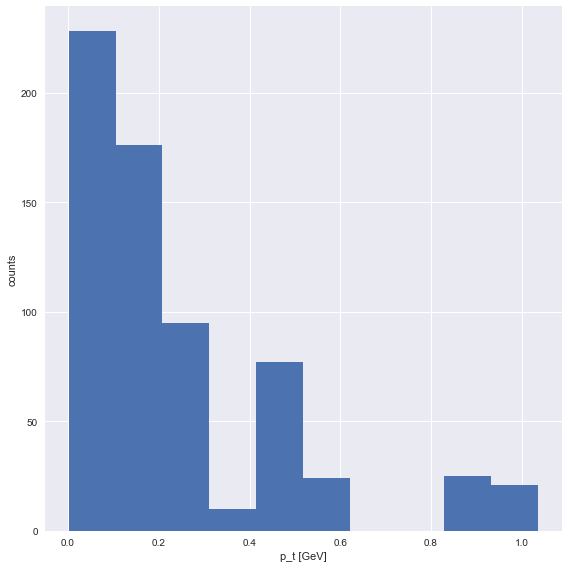

In [30]:
# Using Pyplot API
plt.close('all')
plt.style.use('seaborn')
fig = plt.figure(figsize=(8,8))

plt.hist(particles.pt, bins=10)

plt.xlabel('p_t [GeV]')
plt.ylabel('counts')
# plt.xlim((0.1, 1.5))
# plt.ylim((5, 40))
plt.tight_layout()

In [31]:
# find average hits per track
print("Average number of hits per tracks: {}".format(hits.hit_id.count()/particles.particle_id.unique().size))

Average number of hits per tracks: 25.23076923076923


## _Misc._